In [1]:
import os
os.chdir('/scratch/sagarsj42')

In [2]:
import time
import pickle
import multiprocessing

import numpy as np
import scipy.spatial as sp
import gensim

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        self.activation_function = nn.LogSoftmax(dim=-1)
        
    def forward(self, inputs):
        out = self.embeddings(inputs)
        ct_size = out.shape[1]
        out = (out.sum(1) / ct_size).view(out.shape[0], -1)
        out = self.linear(out)
        out = self.activation_function(out)
        
        return out
    
    def get_embedding(self, word, vocab):
        word_ind = torch.tensor(vocab.index(word), dtype=torch.long)
        return self.embeddings(word_ind).view(1, -1)

In [4]:
checkpoint = torch.load('cbow-checkpoints/checkpoint-6.pt')

vocab = checkpoint['vocab']
print('Vocab size', len(vocab))
print('Samples', vocab[:5])

model_args = checkpoint['model_args']
model = CBOW(**model_args)
print('Model initialized with args',model_args, model)

n_epochs = checkpoint['n_epochs']
print('Model was set to train for epochs:', n_epochs)

model.load_state_dict(checkpoint['state_dict'])
model.eval()
print('Model loaded with trained weights', model.state_dict())

Vocab size 50933
Samples ['<UNK>', 'we', 'got', 'this', 'for']
Model initialized with args {'vocab_size': 50933, 'embedding_dim': 750} CBOW(
  (embeddings): Embedding(50933, 750)
  (linear): Linear(in_features=750, out_features=50933, bias=True)
  (activation_function): LogSoftmax(dim=-1)
)
Model was set to train for epochs: 10
Model loaded with trained weights OrderedDict([('embeddings.weight', tensor([[-1.3609, -1.2371,  1.5244,  ..., -0.5109, -1.2999,  1.2857],
        [-1.0616,  1.2259, -0.0162,  ...,  0.8587, -1.9133,  2.0961],
        [ 0.7162,  1.1400,  0.0630,  ..., -0.9417, -0.7874,  0.1724],
        ...,
        [-1.3106, -0.6954,  0.1102,  ...,  0.3066, -0.1432,  2.4817],
        [ 0.3622,  1.3063,  0.2187,  ..., -0.4506,  0.9396,  0.2432],
        [ 0.1947,  1.4625, -1.4629,  ...,  0.5071,  0.8568,  2.4582]])), ('linear.weight', tensor([[-9.7804e-03,  1.0644e-02,  1.0121e-02,  ...,  1.5885e-02,
          1.1804e-02, -5.1405e-03],
        [ 4.5425e-02,  2.3543e-02,  1.0508e-

In [5]:
e = np.zeros((model_args['vocab_size'], model_args['embedding_dim']))

for i, word in enumerate(vocab):
    we = model.get_embedding(word, vocab).detach().numpy().reshape(-1)
    e[i, :] = we

e.shape

(50933, 750)

In [6]:
w1_e = model.get_embedding('camera', vocab).detach().numpy().reshape(-1, 1)
w1_e.shape

(750, 1)

In [7]:
distances = list()
for w in vocab:
    w2_e = model.get_embedding(w, vocab).detach().numpy().reshape(-1, 1)
    distances.append((sp.distance.cosine(w1_e, w2_e), w))
    
distances[:10]

[(1.0274977926164865, '<UNK>'),
 (0.9704582877457142, 'we'),
 (1.0068004745990038, 'got'),
 (0.969352824613452, 'this'),
 (1.0096714776009321, 'for'),
 (1.0149441165849566, 'my'),
 (0.9747955929487944, 'husband'),
 (1.0142548186704516, 'who'),
 (0.9458516351878643, 'is'),
 (1.0454930812120438, 'an')]

In [8]:
distances.sort(key=lambda t: t[0])
distances[:11]

[(0.0, 'camera'),
 (0.8400475084781647, 'confusions'),
 (0.859504759311676, 'trifling'),
 (0.8614937663078308, 'mountaineering'),
 (0.8617294132709503, 'floats'),
 (0.8627732694149017, 'daffodil'),
 (0.8641412407159805, 'kaleidoscopes'),
 (0.8668143302202225, 'misrepresent'),
 (0.8683671653270721, 'liability'),
 (0.8696934729814529, 'hauled'),
 (0.8711688369512558, 'weavers')]

In [9]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format(
    '~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', binary=True)

w1_e = word2vec['camera']
w1_e.shape

(300,)

In [10]:
distances = list()
for word in vocab:
    try:
        w2_e = word2vec[word]
    except KeyError:
        w2_e = np.zeros(300)
    distances.append((sp.distance.cosine(w1_e, w2_e), word))
    
distances[:10]

/home2/sagarsj42/miniconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[(nan, '<UNK>'),
 (0.9034783244132996, 'we'),
 (0.8751401305198669, 'got'),
 (0.9668513834476471, 'this'),
 (1.0030541874002665, 'for'),
 (0.8633989840745926, 'my'),
 (0.8664259761571884, 'husband'),
 (0.9332376345992088, 'who'),
 (0.9353648945689201, 'is'),
 (0.9466216117143631, 'an')]

In [11]:
distances.sort(key=lambda t: t[0])
distances[:11]

[(nan, '<UNK>'),
 (0.0, 'camera'),
 (0.403339147567749, 'viewfinder'),
 (0.45716017484664917, 'cam'),
 (0.4986976385116577, 'lenses'),
 (0.5297282636165619, 'photos'),
 (0.5543881356716156, 'shutterbug'),
 (0.5810834169387817, 'stereoscopic'),
 (0.5813919603824615, 'laptop'),
 (0.5818691253662109, 'footages'),
 (0.5951479077339172, 'eyepieces')]

In [12]:
e_pca = PCA(n_components=10).fit_transform(e)
e_pca.shape

(50933, 10)

In [13]:
e_tsne = TSNE(n_components=2, perplexity=20, 
              metric='euclidean', init='pca', square_distances=True,
              n_jobs=multiprocessing.cpu_count()).fit_transform(e_pca)
e_tsne.shape

(50933, 2)

In [14]:
select_words = ['jackhammered', 'sharper', 'amid', 'secretion', 'chapeau']
select_ind = [vocab.index(word) for word in select_words]
word_embeds = [e_tsne[i] for i in select_ind]
select_ind

[50397, 4403, 23402, 40100, 35584]

In [15]:
word_distances = dict()

for w, w1_e in zip(select_words, word_embeds):
    distances = list()
    for i in range(50933):
        if vocab.index(w) != i:
            w2_e = e_tsne[i]
            distances.append((vocab[i], w2_e, sp.distance.cosine(w1_e, w2_e)))
    
    distances.sort(key=lambda t: t[2])
    word_distances[w] = (w1_e, distances[:10])

word_distances

{'jackhammered': (array([ 9.2009115, 48.96599  ], dtype=float32),
  [('gunk', array([ 9.093174, 48.35097 ], dtype=float32), 0.0),
   ('knucklehead', array([ 7.5454307, 40.104065 ], dtype=float32), 0.0),
   ('crisps', array([ 6.2068343, 33.066357 ], dtype=float32), 0.0),
   ('overrating', array([ 2.790404, 14.86275 ], dtype=float32), 0.0),
   ('incursion', array([ 3.7349172, 19.84953  ], dtype=float32), 0.0),
   ('governor',
    array([ 5.4007306, 28.666481 ], dtype=float32),
    5.960464477539063e-08),
   ('vacuums',
    array([ 4.328546, 22.975937], dtype=float32),
    1.1920928955078125e-07),
   ('flattering',
    array([ 3.9953618, 21.191868 ], dtype=float32),
    1.1920928955078125e-07),
   ('tong',
    array([1.0742913, 5.7058563], dtype=float32),
    1.1920928955078125e-07),
   ('piddling',
    array([ 8.035636, 42.695683], dtype=float32),
    1.1920928955078125e-07)]),
 'sharper': (array([-38.66903 , -17.976482], dtype=float32),
  [('indifferent', array([-24.930565, -11.591255],

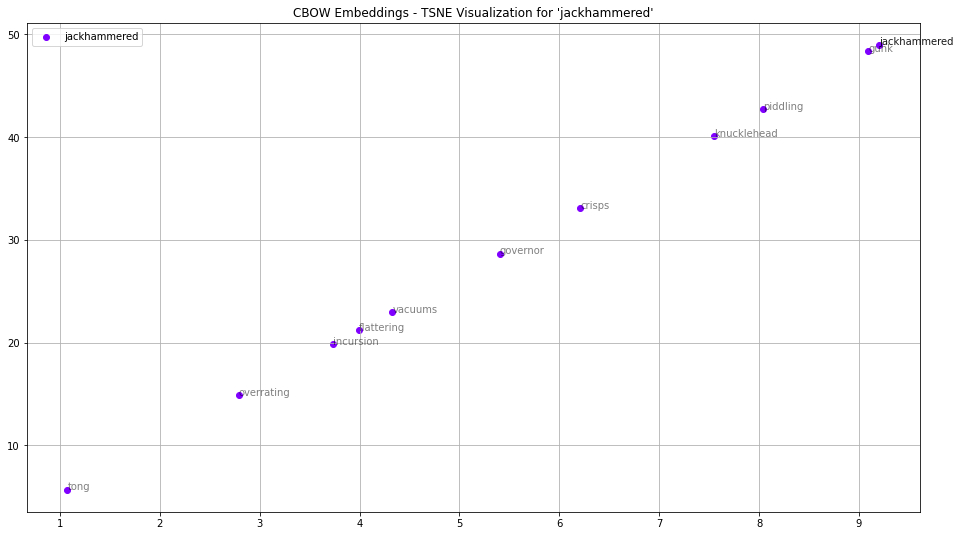

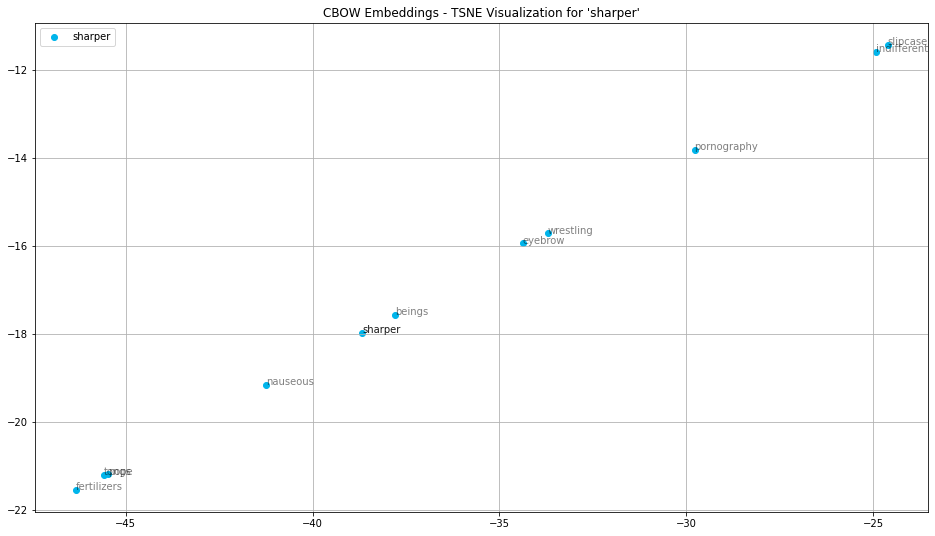

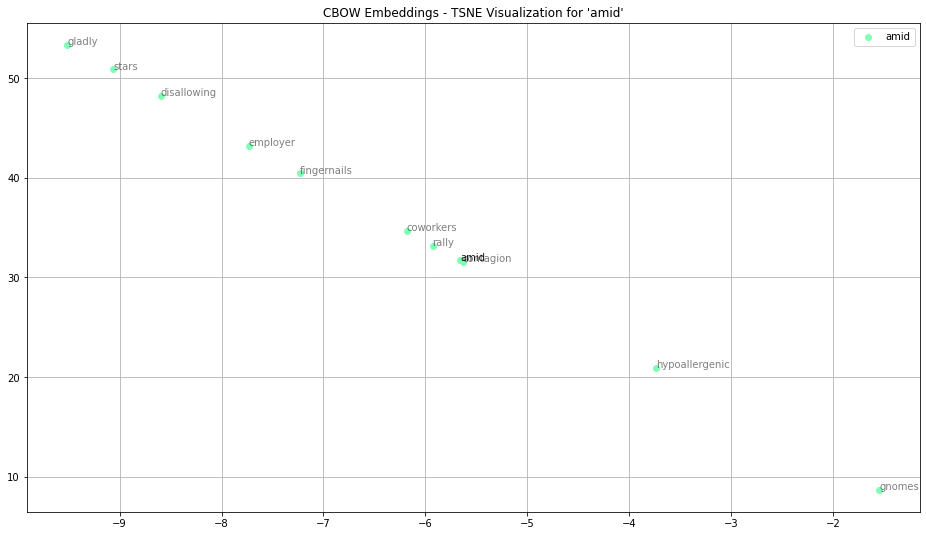

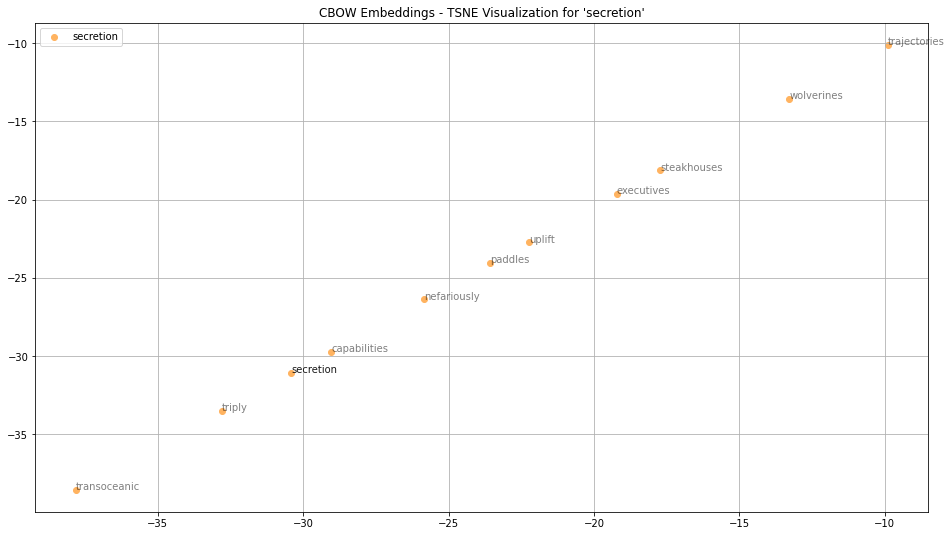

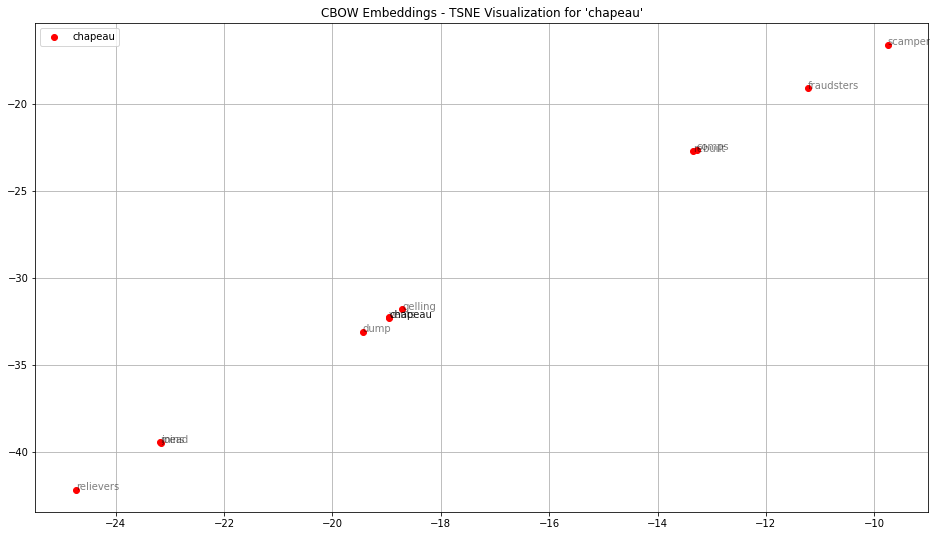

In [16]:
colors = cm.rainbow(np.linspace(0, 1, 5))

for word, color in zip(word_distances, colors):
    plt.figure(figsize=(16, 9))
    w1_e = word_distances[word][0]
    distances = word_distances[word][1]
    x = w1_e[0]
    y = w1_e[1]
    
    plt.scatter(x, y, label=word, color=color)
    plt.annotate(word, alpha=0.9, xy=(x, y))
    
    for d in distances:
        word2 = d[0]
        w2_e = d[1]
        x = w2_e[0]
        y = w2_e[1]
        
        plt.scatter(x, y, color=color)
        plt.annotate(word2, alpha=0.5, xy=(x, y))
    
    plt.title('CBOW Embeddings - TSNE Visualization for \'' + word + '\'')
    plt.legend()
    plt.grid()
    plt.savefig('cbow-'+word+'.png')
    plt.show()

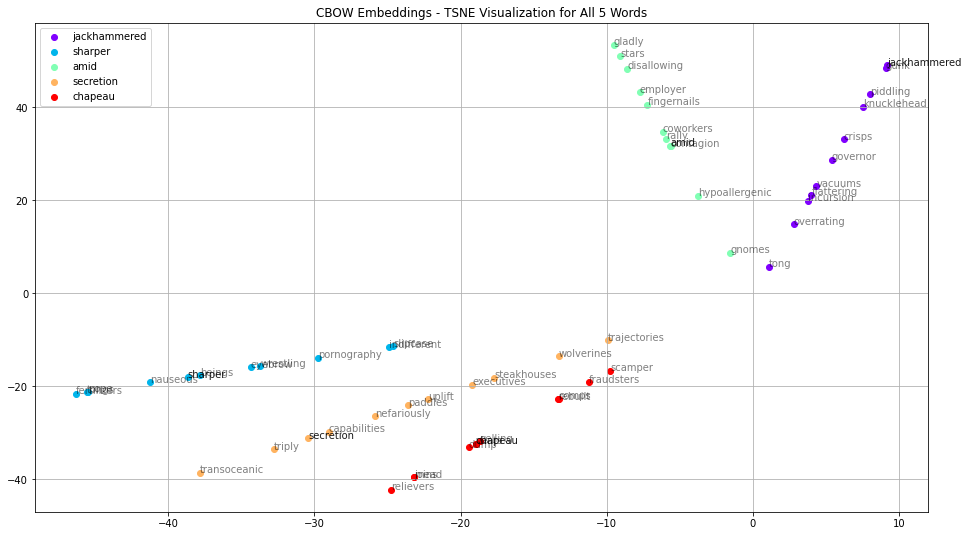

In [17]:
colors = cm.rainbow(np.linspace(0, 1, 5))
plt.figure(figsize=(16, 9))

for word, color in zip(word_distances, colors):
    w1_e = word_distances[word][0]
    distances = word_distances[word][1]
    x = w1_e[0]
    y = w1_e[1]
    
    plt.scatter(x, y, label=word, color=color)
    plt.annotate(word, alpha=0.9, xy=(x, y))
    
    for d in distances:
        word2 = d[0]
        w2_e = d[1]
        x = w2_e[0]
        y = w2_e[1]
        
        plt.scatter(x, y, color=color)
        plt.annotate(word2, alpha=0.5, xy=(x, y))
    
plt.title('CBOW Embeddings - TSNE Visualization for All 5 Words')
plt.legend()
plt.grid()
plt.savefig('cbow-all.png')
plt.show()